In [1]:
import roboflo as rf
import numpy as np

# Quick initialization of our system

Please refer to the "basic usage.ipynb" example if this section doesn't make sense

In [2]:
hotplate = rf.Worker(
    name='hotplate',
    capacity=8
)

spincoater = rf.Worker(
    name='spincoater',
    capacity=1
)

storage = rf.Worker(
    name='storage',
    capacity=45,
    initial_fill=45 #the storage starts full!
)

characterization = rf.Worker(
    name='characterization line',
    capacity=1
)

arm = rf.Worker(
    name='arm',
    capacity=1
)

In [37]:
transitions = [
    rf.Transition(
        duration=28,
        source=storage,
        destination=spincoater,
        workers=[arm]
    ),
    rf.Transition(
        duration=20,
        source=spincoater,
        destination=hotplate,
        workers=[arm]
    ),
    rf.Transition(
        duration=20,
        source=spincoater,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=hotplate,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=storage,
        destination=characterization,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=characterization,
        destination=storage,
        workers=[arm]
    ),
    rf.Transition(
        duration=15,
        source=characterization,
        destination=hotplate,
        workers=[arm]
    )
]

# Setting breakpoints on high-priority tasks

Any task can be assigned as a "breakpoint" task by setting `rf.Task(breakpoint=True)`. When solving the schedule, `roboflo` will break the total task list into chunks, divided at each breakpoint. For a given protocol, the first "chunk" will contain tasks up to the first "breakpoint" task, and then all "immediate" tasks following. The second "chunk" will contain tasks to the next "breakpoint" + "immediate" antecedents, etc. The overall schedule will be solved one chunk at a time.

The purpose of "breakpoints" are to provide priority to certain tasks that must occur as early as possible in the schedule. Example: when spincoating on glass substrates, the glass is cleaned prior to the experiment start to allow for good coating. The longer the glass sits idle, the worse the coating will be, so we set the first spincoating `Task` as a "breakpoint" to get them done as early as possible

In [63]:
def add_generic_protocol(breakpoint_on_first_spincoat = False):
    """
    Makes a protocol with some random durations to simulate changing parameters as the experiment progresses
    """
    system.generate_protocol(
        worklist = [
            rf.Task(
                name='spincoat',
                workers=[spincoater],
                duration=40 + np.random.random()*20,
                immediate=True,
                breakpoint=breakpoint_on_first_spincoat, #If we want to solve the schedule up to this task first, this should be True
            ),
            rf.Task(
                name='anneal',
                workers=[hotplate],
                duration=np.random.choice([180, 240, 360]),
                immediate=True
            ),
            rf.Task(
                name='rest',
                workers=[storage],
                duration=180,
                immediate=True
            ),
            rf.Task(
                name='spincoat again',
                workers=[spincoater],
                duration = 130,
                immediate=False
            ),
            rf.Task(
                name='rest',
                workers=[storage],
                duration=180,
                immediate=False,
            ),
            rf.Task(
                name='characterize',
                workers=[characterization],
                duration=500,
                immediate=False
            ),
],
        min_start=0
    )

## Solve without breakpoints

In [64]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage,
)

In [65]:
for i in range(10): #10 sample example experiment
    add_generic_protocol(
        breakpoint_on_first_spincoat=False,
        )

In this example, the first spincoater step per protocol is much shorter than the second, and is immediately followed by heating on the hotplate. Note that there are gaps in the hotplate schedule, interwoven short/long spincoat steps, and a total runtime of <1.75 hrs

Solving final schedule
	solution status: OPTIMAL


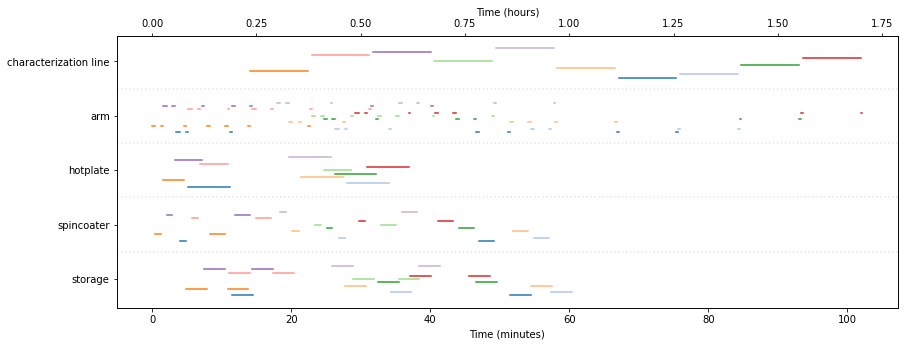

In [66]:
system.scheduler.solve(
    solve_time=10,
)
system.scheduler.plot_solution()

## Solve with breakpoint on first spincoat `Task`

In [67]:
system = rf.System(
    workers=[storage, spincoater, hotplate, arm, characterization],
    transitions=transitions,
    starting_worker=storage,
    ending_worker=storage,
)

In [68]:
for i in range(10): #10 sample example experiment
    add_generic_protocol(
        breakpoint_on_first_spincoat=True,
        )

Now you see that all short spincoat steps complete before the long steps begin. The total experiment time has increased, but we have prioritized the time sensitive steps to happen as early as possible!

Solving intermediate schedule up to breakpoint 0
	solution status: OPTIMAL
Solving final schedule
	solution status: OPTIMAL


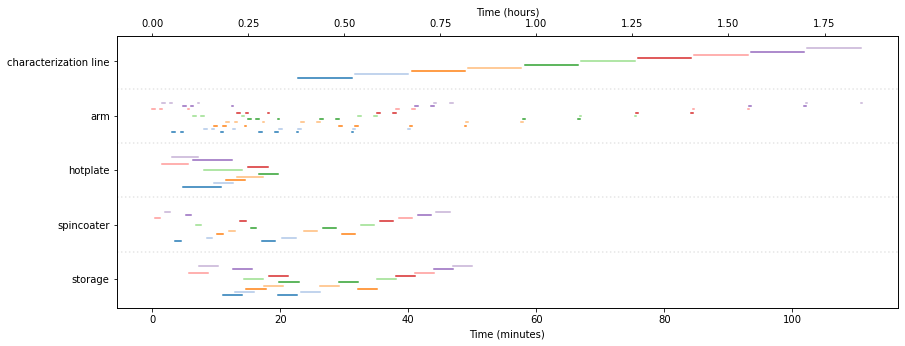

In [69]:
system.scheduler.solve(
    solve_time=10,
)
system.scheduler.plot_solution()